In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import glob

import torch
from torchvision.transforms import v2
import torchvision.transforms.functional as TF

from utils.utilities import plot

In [7]:
os.listdir('data')

['FIVES A Fundus Image Dataset for AI-based Vessel Segmentation', 'training']

In [2]:
og = plt.imread('data/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Original/1_A.png')
og.shape

(2048, 2048, 3)

In [4]:
seg = plt.imread('data/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Ground truth/1_A.png')
seg.shape

(2048, 2048, 3)

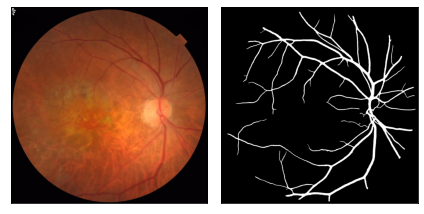

In [5]:
plot([og,seg])

### Pre-processing

#### Gaussian Blur

In [ ]:
cv2.media

In [94]:
filter_size = 65
mean = 0
sigma = 100

In [100]:
# for i in range(3)
og_blurred = cv2.GaussianBlur(og,(filter_size,filter_size),sigma)

In [101]:
og_enhanced = cv2.subtract(og,og_blurred, dtype=cv2.CV_32F)
og_enhanced = cv2.normalize(og_enhanced, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

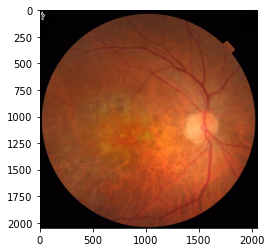

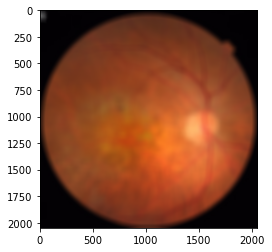

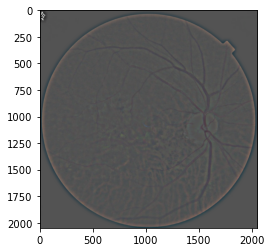

In [102]:
plt.imshow(og)
plt.show()
plt.imshow(og_blurred)
plt.show()
plt.imshow(og_enhanced)
plt.show()

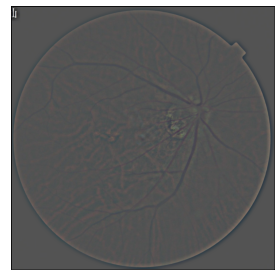

In [13]:
from PIL import Image
from skimage.filters import gaussian
import cv2

def gaussian_blur(img, filter_size=65, sigma=40):
    #image = np.array(img)
    image_blur = cv2.GaussianBlur(img,(filter_size,filter_size),sigma)
    # new_image = cv2.subtract(img,image_blur).astype('float32') # WRONG, the result is not stored in float32 directly
    new_image = cv2.subtract(img,image_blur, dtype=cv2.CV_32F)
    out = cv2.normalize(new_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return out

img = gaussian_blur(img)
plot([img])

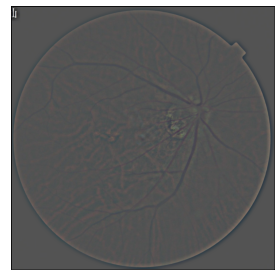

In [14]:
img = Image.fromarray(img.astype('uint8'), 'RGB')
plot([img])

### data augmentation

In [3]:
from utils.preprocessing import local_enhancement
from utils.utilities import get_label_from_filename

In [4]:
data_path = "data/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/original"

admissible_labels = ["A","N"]

images = []
labels = []

for img_path in glob.glob(os.path.join(data_path,"*.png")):
    
    label = get_label_from_filename(img_path)

    if label in admissible_labels:
        labels.append(label)
        img = plt.imread(img_path)
        img_enh = local_enhancement(img,65,40,True)
        images.append(img_enh)

    if len(label)>=50:
        break


In [4]:
np.unique(labels,return_counts=True)

(array(['A', 'N'], dtype='<U1'), array([150, 150], dtype=int64))

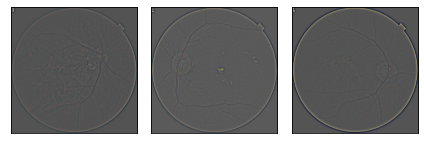

In [5]:
plot(images[:3])

In [18]:
torch.stack(images[:50]).shape

RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 2516582400 bytes.

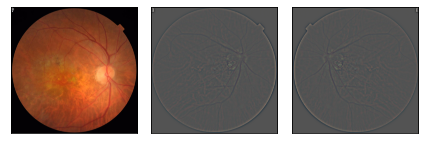

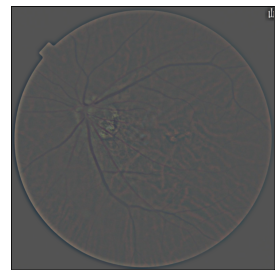

In [8]:
img = images[0]
flip = TF.hflip(img)
plot([og,img,flip])
plot([flip])

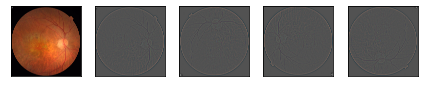

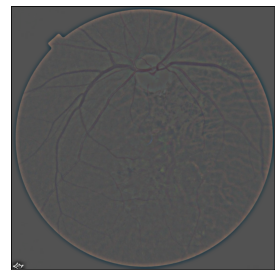

In [26]:
out_90 = TF.rotate(img,angle=90)
out_180 = TF.rotate(img,angle=180)
out_270 = TF.rotate(img,angle=270)
plot([og,img,out_90,out_180,out_270])
plot([out_90])

In [22]:
from torchio import RandomElasticDeformation
elastic_transformer = RandomElasticDeformation(
    num_control_points=100,  # or just 7
    max_displacement=20,
    locked_borders=2,
)
deform = elastic_transformer(TF.pil_to_tensor(img))
plot([img, deform])

ValueError: The input must be a 4D tensor with dimensions (channels, x, y, z) but it has shape (3, 2048, 2048). Tips: if it is a volume, please add the channels dimension; if it is 2D, also add a dimension of size 1 for the z axis

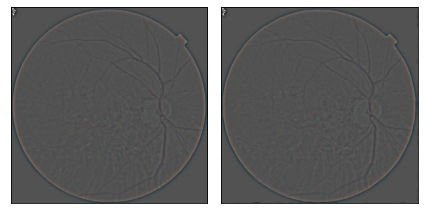

In [23]:
elastic_transformer = v2.ElasticTransform(300,20)
deform = elastic_transformer(img)
plot([img, deform])

In [30]:
TF.to_tensor(out_90)

tensor([[[0.3216, 0.3216, 0.3216,  ..., 0.3216, 0.3216, 0.3216],
         [0.3176, 0.3176, 0.3176,  ..., 0.3216, 0.3216, 0.3216],
         [0.3176, 0.3176, 0.3176,  ..., 0.3216, 0.3216, 0.3216],
         ...,
         [0.1804, 0.1804, 0.1804,  ..., 0.3216, 0.3216, 0.3216],
         [0.1804, 0.1804, 0.1804,  ..., 0.3216, 0.3216, 0.3216],
         [0.1804, 0.1804, 0.1804,  ..., 0.3216, 0.3216, 0.3216]],

        [[0.3216, 0.3216, 0.3216,  ..., 0.3216, 0.3216, 0.3216],
         [0.3216, 0.3216, 0.3216,  ..., 0.3216, 0.3216, 0.3216],
         [0.3216, 0.3216, 0.3216,  ..., 0.3216, 0.3216, 0.3216],
         ...,
         [0.1804, 0.1804, 0.1804,  ..., 0.3216, 0.3216, 0.3216],
         [0.1804, 0.1804, 0.1804,  ..., 0.3216, 0.3216, 0.3216],
         [0.1804, 0.1804, 0.1804,  ..., 0.3216, 0.3216, 0.3216]],

        [[0.3216, 0.3216, 0.3216,  ..., 0.3216, 0.3216, 0.3216],
         [0.3176, 0.3176, 0.3176,  ..., 0.3216, 0.3216, 0.3216],
         [0.3176, 0.3176, 0.3176,  ..., 0.3216, 0.3216, 0.

In [31]:
from torchvision.models import resnet50

In [32]:
net = resnet50()

In [38]:
for p in net.parameters():
    print(p.shape)

torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([64, 256, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([64, 256, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([128, 256, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([512, 128, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([512, 256, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([128, 512, 1, 1])
torch.Size([128])
torch.Siz